In [1]:
from sklearn.svm import SVR, LinearSVR
import pandas as pd
import numpy as np
import matplotlib
from sklearn.model_selection import StratifiedKFold, KFold, LeaveOneOut, GridSearchCV
from sklearn import preprocessing
import seaborn as sns
import scipy.stats as stats
import scipy.io as sio
import sklearn
import sys
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from scipy.stats import pearsonr, spearmanr, permutation_test # need python3.8
import warnings
from pycirclize import Circos
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings('ignore')

In [2]:
def compute_statistic(x, y):
    return stats.pearsonr(x, y)[0]

In [3]:
# Load data
featurepath='/media/shuang/data/BrainAge/Brain_age_scripts/network_features/'
hc_fc_data = pd.read_csv(featurepath+'FC_HC_mean.csv', header=None)
hc_sc_data = pd.read_csv(featurepath+'SC_HC_mean.csv', header=None)
hc_msn_data = pd.read_csv(featurepath+'MSN_HC_mean.csv', header=None)
hc_age_data = pd.read_excel('/media/shuang/data/BrainAge/Brain_age_scripts/data/HC_age.xlsx')
eos_fc_data = pd.read_csv(featurepath+'FC_EOS_mean.csv', header=None)
eos_sc_data = pd.read_csv(featurepath+'SC_EOS_mean.csv', header=None)
eos_msn_data = pd.read_csv(featurepath+'MSN_EOS_mean.csv', header=None)
eos_age_data = pd.read_excel('/media/shuang/data/BrainAge/Brain_age_scripts/data/EOS_age.xlsx')

hc_fc_data = np.array(hc_fc_data.iloc[2:, :])
hc_sc_data = np.array(hc_sc_data.iloc[2:, :])
hc_msn_data = np.array(hc_msn_data.iloc[2:, :])
hc_age_data = np.array(hc_age_data)
eos_fc_data = np.array(eos_fc_data.iloc[2:, :])
eos_sc_data = np.array(eos_sc_data.iloc[2:, :])
eos_msn_data = np.array(eos_msn_data.iloc[2:, :])
eos_age_data = np.array(eos_age_data)

In [4]:
# Choose one modal data
hc_data = hc_msn_data
eos_data = eos_msn_data

In [5]:
# Normalized data
y_hc = hc_age_data[:, 0]
y_eos = eos_age_data[:, 0]
min_max_scaler = preprocessing.StandardScaler()
min_max_scaler = min_max_scaler.fit(hc_data) # fit training set
x_hc = min_max_scaler.transform(hc_data) 
x_eos = min_max_scaler.transform(eos_data)
t_value = stats.ttest_ind(x_hc,x_eos)
t_value = t_value.statistic
print(x_hc.shape, x_eos.shape)

(91, 253) (80, 253)


In [6]:
# Select features
select_id = sio.loadmat('/media/shuang/data/BrainAge/Brain_age_scripts/output/FeaturesS_MSN_RF.mat')['saved_msnidx'][0, :]
print(len(select_id))

36


In [7]:
# Predicting
y_pred_hc = np.zeros((y_hc.shape[0],))
# repeat 50 times; 10 fold cv
num_folds = 10
num_repeats = 50
all_y_pred_hc = np.zeros((num_repeats, y_hc.shape[0]))
all_y_pred_eos = np.zeros((num_repeats, num_folds, y_eos.shape[0]))
coef = np.zeros((num_repeats, num_folds, x_hc.shape[1]))
param_grid={"n_estimators":np.linspace(50,400,50, dtype=int),"max_depth":np.linspace(8,16,2, dtype=int)}
count = 0
for repeat in range(num_repeats):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=repeat)
    k = 0
    print(count)
    for train_index, test_index in kf.split(x_hc):
        estimator = RandomForestRegressor()
        X_train, X_test = x_hc[train_index], x_hc[test_index]
        y_train, y_test = y_hc[train_index], y_hc[test_index]
        # Select features survive REFCV
        select_index = select_id
        X_train = np.array(X_train)[:,select_index]
        X_test = np.array(X_test)[:,select_index]
        # training model
        grid_search = GridSearchCV(estimator, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        # predicting test data of HC
        best_model = grid_search.best_estimator_
        print(grid_search.best_params_)
        y_pred_hc = best_model.predict(X_test)
        coef[repeat,k,select_index] = best_model.feature_importances_
        print(y_pred_hc.shape)
        all_y_pred_hc[repeat, test_index] = y_pred_hc
        # predicting EOS data
        x_eos_sf = np.array(x_eos)[:,select_index] # selected features
        y_pred_eos = best_model.predict(x_eos_sf)
        all_y_pred_eos[repeat, k, :] = y_pred_eos
        k = k + 1
        count = count + 1

0
{'max_depth': 16, 'n_estimators': 150}
(10,)
{'max_depth': 16, 'n_estimators': 57}
(9,)
{'max_depth': 16, 'n_estimators': 150}
(9,)
{'max_depth': 16, 'n_estimators': 114}
(9,)
{'max_depth': 16, 'n_estimators': 50}
(9,)
{'max_depth': 16, 'n_estimators': 107}
(9,)
{'max_depth': 16, 'n_estimators': 214}
(9,)
{'max_depth': 16, 'n_estimators': 57}
(9,)
{'max_depth': 16, 'n_estimators': 328}
(9,)
{'max_depth': 16, 'n_estimators': 50}
(9,)
10
{'max_depth': 16, 'n_estimators': 135}
(10,)
{'max_depth': 8, 'n_estimators': 128}
(9,)
{'max_depth': 8, 'n_estimators': 228}
(9,)
{'max_depth': 8, 'n_estimators': 78}
(9,)
{'max_depth': 16, 'n_estimators': 107}
(9,)
{'max_depth': 8, 'n_estimators': 314}
(9,)
{'max_depth': 16, 'n_estimators': 50}
(9,)
{'max_depth': 8, 'n_estimators': 85}
(9,)
{'max_depth': 16, 'n_estimators': 235}
(9,)
{'max_depth': 16, 'n_estimators': 400}
(9,)
20
{'max_depth': 8, 'n_estimators': 135}
(10,)
{'max_depth': 8, 'n_estimators': 321}
(9,)
{'max_depth': 16, 'n_estimators': 9

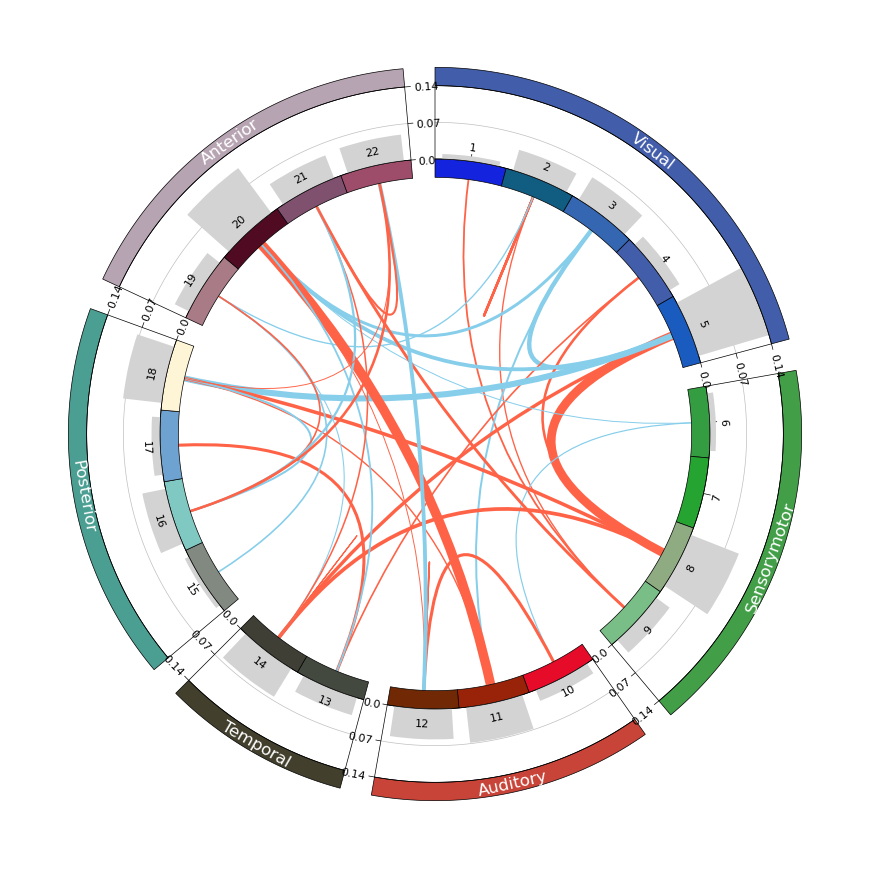

In [8]:
# network label and weights
df = pd.DataFrame(pd.read_csv(featurepath+'FC_HC_mean.csv', header=None)).loc[0:1,:] # read network label
#df.loc[2]=np.zeros(len(df.loc[0])) # FC
#df.loc[2][a]=np.mean(np.mean(coef,axis=0),axis=0)# FC
df.loc[2]=np.mean(np.mean(coef,axis=0),axis=0)
weightmap = np.zeros((22,22))
select_index = np.nonzero(df.loc[2]) # for all models 50*10
for i in range(df.shape[1]):
    weightmap[int(df.iloc[0,i])-1,int(df.iloc[1,i])-1] = df.iloc[2,i] # low
coef_node = np.sum(np.abs((weightmap+weightmap.T)/2), axis = 1) # first absolute then sum
# Initialize Circos sectors
np.random.seed(0)
sectors = {"Visual": 5, "Sensorymotor": 4, "Auditory": 3, "Temporal": 2,
           "Posterior": 4, "Anterior": 4}
name2color = {"Visual": (66/256, 93/256, 170/256), "Sensorymotor": (66/256, 160/256, 72/256), "Auditory": (202/256, 68/256, 56/256),
              "Temporal": (66/256, 63/256, 45/256),
           "Posterior": (75/256, 160/256, 147/256),
              "Anterior": (184/256, 165/256, 179/256)}
cmap22 = {"Visual": (66/256, 93/256, 170/256), "Sensorymotor": (66/256, 160/256, 72/256), "Auditory": (202/256, 68/256, 56/256),
              "Temporal": (66/256, 63/256, 45/256),
           "Posterior": (75/256, 160/256, 147/256),
              "Anterior": (184/256, 165/256, 179/256)}
circos = Circos(sectors, space=5)
network=[1,1,1,1,1,2,2,2,2,3,3,3,4,4,5,5,5,5,6,6,6,6]
ind=[0,1,2,3,4,0,1,2,3,0,1,2,0,1,0,1,2,3,0,1,2,3]
cmap22 = {"1": (20/256, 35/256, 223/256), "2": (17/256, 93/256, 131/256), "3": (52/256, 102/256, 179/256), "4": (66/256, 93/256, 170/256),
           "5": (26/256, 91/256, 193/256),
          "6": (52/256, 158/256, 66/256),"7": (38/256, 165/256, 49/256), "8": (144/256, 172/256, 131/256), "9": (121/256, 191/256, 135/256),
          "10": (232/256, 11/256, 42/256), "11": (154/256, 35/256, 8/256), "12": (112/256, 40/256, 5/256),
           "13": (68/256, 73/256, 63/256), "14": (63/256, 63/256, 54/256),
          "15": (131/256, 138/256, 128/256), "16": (128/256, 202/256, 196/256), "17": (110/256, 163/256, 209/256), "18": (255/256, 246/256, 216/256),
          "19": (170/256, 123/256, 135/256), "20": (80/256, 11/256, 35/256), "21": (128/256, 81/256, 110/256), "22": (158/256, 77/256, 105/256)}
# Plot sector name
i=1
c=0
for sector in circos.sectors:
    # Plot 6 network name
    track = sector.add_track((95, 100))
    track.axis(fc=name2color[sector.name])
    track.text(sector.name, color="white", size=12)
    # Plot 22 networks
    track2 = sector.add_track((70, 75))
    x = np.arange(sector.start, sector.end)+0.5
    xlabels = [str(int(v + 1 + c)) for v in x]
    track2.xticks(x, xlabels, outer=True)
    for idx in range(int(sector.start), int(sector.end)):
        track2.rect(idx, idx + 1, fc=cmap22[xlabels[idx]], ec="black", lw=0.5,alpha=1)
    c=c+int(sector.end)
    # Plot bar
    myelement=i
    y = coef_node[[i for i, n in enumerate(network) if n == myelement]]
    track1 = sector.add_track((75, 95))
    track1.axis()
    track1.bar(x, y,vmin=0, vmax=max(coef_node), fc="lightgrey") # need change to the max coef_node
    track1.grid(3)
    l = np.linspace(0,round(max(coef_node),2),3)
    l_labels = list(map(str, l))
    track1.yticks(l, l_labels)
    i=i+1
# Plot links 
for i in select_index[0]:
    row = int(df.iloc[0,i])-1 #22
    col = int(df.iloc[1,i])-1 #22
    if t_value[i] > 0: # positive means EOS > HC
    #if best_model.coef_[0][i] > 0:
        circos.link_line((pd.DataFrame(sectors.keys()).iloc[network[row]-1].iloc[0],ind[row]+0.5),
                         (pd.DataFrame(sectors.keys()).iloc[network[col]-1].iloc[0],ind[col]+0.5),
                         color="tomato", lw=abs(df.loc[2][i])*70) # lw is weight of edge
    elif t_value[i] < 0:
        circos.link_line((pd.DataFrame(sectors.keys()).iloc[network[row]-1].iloc[0],ind[row]+0.5),
                         (pd.DataFrame(sectors.keys()).iloc[network[col]-1].iloc[0],ind[col]+0.5),
                         color="skyblue", lw=abs(df.loc[2][i])*70)
# Plot figure & set legend on center
fig = circos.plotfig(figsize=(8,8))
#plt.savefig('/media/shuang/data/BrainAge/Glasser360/figures/feature_weights_FC.svg', dpi=1000, transparent=True)

In [10]:
y_pred_eos_50 = np.mean(all_y_pred_eos, axis=1)
HC_pearson_perm = np.zeros((all_y_pred_hc.shape[0],2))
EOS_pearson_perm = np.zeros((all_y_pred_hc.shape[0],2))
HC_MAE = np.zeros((all_y_pred_hc.shape[0]))
EOS_MAE = np.zeros((all_y_pred_hc.shape[0]))
HC_R2 = np.zeros((all_y_pred_hc.shape[0]))
EOS_R2 = np.zeros((all_y_pred_hc.shape[0]))
for i in range(all_y_pred_hc.shape[0]):
        temp = stats.pearsonr(y_hc, all_y_pred_hc[i,:])
        HC_pearson_perm[i,0] = temp.statistic
        HC_pearson_perm[i,1] = temp.pvalue
        temp = stats.pearsonr(y_eos, y_pred_eos_50[i,:])
        EOS_pearson_perm[i,0] = temp.statistic
        EOS_pearson_perm[i,1] = temp.pvalue
        HC_MAE[i] = sklearn.metrics.mean_absolute_error(y_hc, all_y_pred_hc[i,:])
        EOS_MAE[i] = sklearn.metrics.mean_absolute_error(y_eos, y_pred_eos_50[i,:])
        HC_R2[i] = sklearn.metrics.r2_score(y_hc, all_y_pred_hc[i,:])
        EOS_R2[i] = sklearn.metrics.r2_score(y_eos, y_pred_eos_50[i,:])

In [30]:
# Loading PANSS scores
select_id_panss = pd.read_csv('/media/shuang/data/BrainAge/Brain_age_scripts/data/select_id_panss.csv', header=None)
select_id_panss = select_id_panss[0]
panss = pd.read_csv('/media/shuang/data/BrainAge/Brain_age_scripts/data/panss_59.csv', header=None)
brainage_panss=y_pred_eos_50[:,select_id_panss]
agegap_panss=agegap_eos[:,select_id_panss]

r mean: [0.1440491  0.21876191 0.16113323 0.24463247 0.22710651]
r std: [0.00643166 0.00693543 0.00652311 0.00548117 0.00694382]
p mean: [0.27694831 0.09646062 0.22333508 0.06209063 0.08411229]
p std: [0.02200508 0.01078348 0.01921824 0.00602145 0.00986629]


(30.0, 120.0)

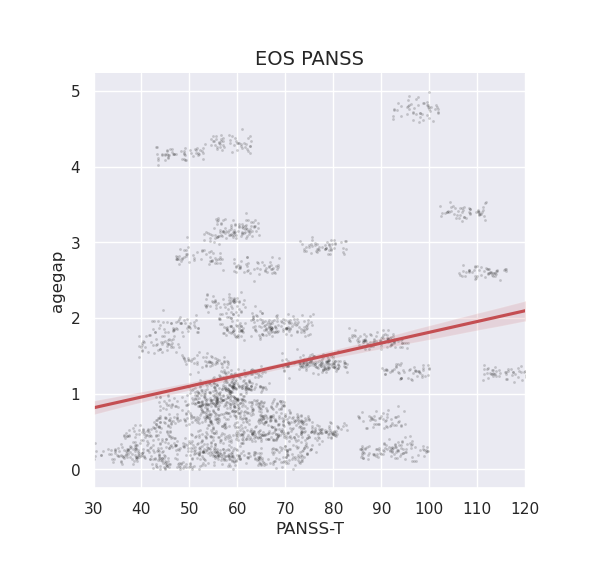

In [54]:
# Pearson's r vaules between age gap and panss
panss_corr=np.zeros((agegap_panss.shape[0],panss.shape[1]))
panss_corrp=np.zeros((agegap_panss.shape[0],panss.shape[1]))
for i in range(agegap_panss.shape[0]):
    for j in range(panss.shape[1]):
        temp = stats.pearsonr(panss.loc[:,j], np.abs(agegap_panss[i,:]))
        #temp = stats.spearmanr(panss.loc[:,j], np.abs(agegap_panss[i,:]))
        panss_corr[i,j] = temp.statistic
        panss_corrp[i,j] = temp.pvalue
print('r mean:',np.mean(panss_corr,axis=0))
print('r std:',np.std(panss_corr,axis=0))
print('p mean:',np.mean(panss_corrp,axis=0))
print('p std:',np.std(panss_corrp,axis=0))
# plotting correlation between brain age and panss
plotdata = np.zeros((agegap_panss.shape[0]*agegap_panss.shape[1],6))
count = 0
for i in range(agegap_panss.shape[1]):
    plotdata[count:count+agegap_panss.shape[0],0:5] = [panss.loc[i,:]]*agegap_panss.shape[0]
    plotdata[count:count+agegap_panss.shape[0],5] = np.abs(agegap_panss[:,i])
    count = count + agegap_panss.shape[0]
plotdata=pd.DataFrame(plotdata)
plotdata.rename(columns={0: 'PANSS-P',1: 'PANSS-N',2: 'PANSS-G',3: 'PANSS-S',4: 'PANSS-T', 5: 'agegap'}, inplace=True) 
sns.set_theme(style="darkgrid")
# plot brain age and actual age
g=sns.catplot(
    data=plotdata, x='PANSS-T', y='agegap', size=2,jitter=5,alpha=0.2,
    native_scale=True, zorder=1, color="k" ) # zorder for its priority
sns.regplot(
    data=plotdata, x='PANSS-T', y='agegap', ci=95, ax=g.ax,
    scatter=False, truncate=False, order=1, color="r")
g.ax.set_title('EOS PANSS', fontsize=14)
g.ax.set_xlim(30,120)
#plt.savefig('/media/shuang/data/BrainAge/Glasser360/figures/PANSSTMSN.svg')

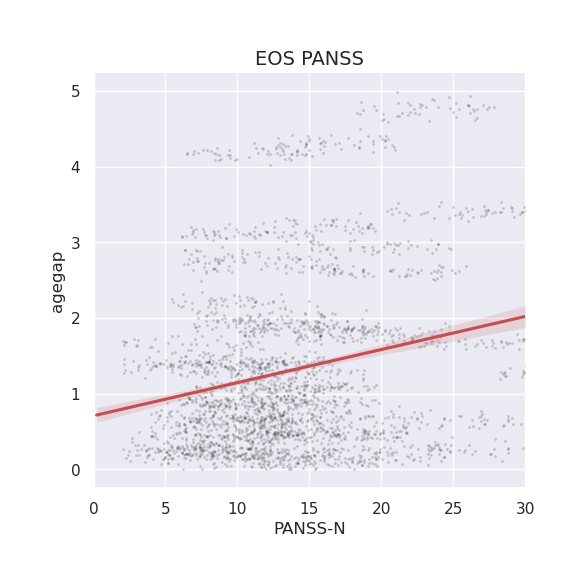

In [53]:
# PANSS sub-scores
plotdata=pd.DataFrame(plotdata)
plotdata.rename(columns={0: 'PANSS-P',1: 'PANSS-N',2: 'PANSS-G',3: 'PANSS-S',4: 'PANSS-T', 5: 'agegap'}, inplace=True) 
sns.set_theme(style="darkgrid")
# plot brain age and actual age
g=sns.catplot(
    data=plotdata, x='PANSS-N', y='agegap', size=2,jitter=5,alpha=0.2,
    native_scale=True, zorder=1, color="k" ) # zorder for its priority
sns.regplot(
    data=plotdata, x='PANSS-N', y='agegap', ci=95, ax=g.ax,
    scatter=False, truncate=False, order=1, color="r")
g.ax.set_title('EOS PANSS', fontsize=14)
g.ax.set_xlim(0,30)
#plt.savefig('/media/shuang/data/BrainAge/Glasser360/figures/PANSSNMSN.svg')

In [14]:
# Pearson's r vaules between brain age and panss
panss_corr=np.zeros((brainage_panss.shape[0],panss.shape[1]))
panss_corrp=np.zeros((brainage_panss.shape[0],panss.shape[1]))
for i in range(brainage_panss.shape[0]):
    for j in range(panss.shape[1]):
        temp = stats.pearsonr(panss.loc[:,j], brainage_panss[i,:])
        panss_corr[i,j] = temp.statistic
        panss_corrp[i,j] = temp.pvalue
print(np.mean(panss_corr,axis=0))
print(np.mean(panss_corrp,axis=0))

[ 0.10075005 -0.02163904  0.07183307 -0.02110375  0.06064423]
[0.44841954 0.87109618 0.58933682 0.87413063 0.64864877]
